In [62]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [63]:
import pyodbc

In [91]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=51.222.82.146;DATABASE=STRATEGIO_OLAP_PROTISA;UID=Cesar_VS;PWD=Atenasmf626;Trusted_Connection=no')
query = "SELECT [CodigoFecha],SUM([VentaSinIgv]) AS Ventas FROM [STRATEGIO_OLAP_PROTISA].[pbix].[Ventas] WHERE [CodigoFecha]>='2019-01-01' and [CodigoFecha]<= getdate()  and [CodigoDistribuidor] not in ('20100239559.0','20100239559.1','20100239559.2','20100239559.3','20100239559.7','20100239559.9') GROUP BY [CodigoFecha]" 
df = pd.read_sql(query,sql_conn)

In [92]:
df.head(4)

,CodigoFecha,Ventas
0,2020-07-29,2.396615e+06
1,2019-09-01,3.165561e+04
2,2021-02-23,2.511046e+06
3,2020-03-28,2.085531e+06


In [93]:
df['CodigoFecha'] = pd.to_datetime(df['CodigoFecha'], format='%Y/%m/%d')
df = df.set_index('CodigoFecha')
df = df.rename(columns={'Ventas': 'y'})
df = df.resample('D').sum()
df = df['y']
df = df.sort_index()

In [95]:
df.fillna(df.mean(),inplace=True)

In [96]:
# Verificar que un índice temporal está completo
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),
                              end=df.index.max(),
                              freq=df.index.freq)).all()

True

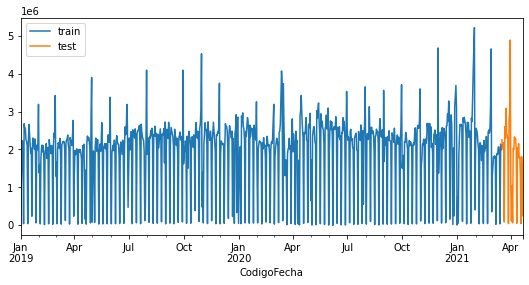

In [97]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = df[:-steps]
datos_test  = df[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [72]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=6
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3 4 5 6]
Exogenous variable: False
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

In [73]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

CodigoFecha
2020-08-23    1.436613e+07
2020-08-30    1.411144e+07
2020-09-06    1.469330e+07
2020-09-13    1.400129e+07
2020-09-20    1.410651e+07
Freq: W-SUN, dtype: float64

In [74]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=6
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3 4 5 6]
Exogenous variable: False
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

In [75]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head(10)

CodigoFecha
2020-08-23    1.436613e+07
2020-08-30    1.411144e+07
2020-09-06    1.469330e+07
2020-09-13    1.400129e+07
2020-09-20    1.410651e+07
2020-09-27    1.414016e+07
2020-10-04    1.430635e+07
2020-10-11    1.393178e+07
2020-10-18    1.417213e+07
2020-10-25    1.407056e+07
Freq: W-SUN, dtype: float64

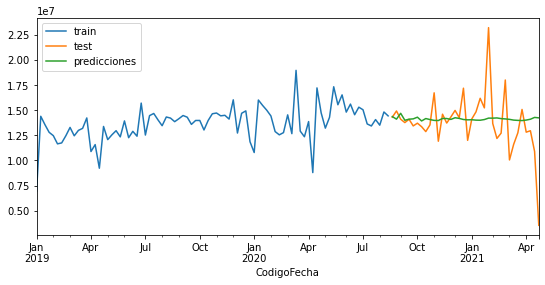

In [76]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [77]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 8167812812592.889


In [78]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [5, 10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'neg_mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.49s/it]
2021-04-21 15:36:11,265 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [1 2 3 4 5] 
params: {'max_depth': 3, 'n_estimators': 100}



In [79]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",3.455852e+12
7,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",3.522334e+12
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 1000}",3.577443e+12
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",3.589845e+12
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 1000}",3.604717e+12
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",3.610954e+12
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 1000}",3.613201e+12
6,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 100}",3.616378e+12
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",3.619199e+12
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",3.619281e+12


In [80]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )

forecaster_rf.fit(y=datos_train)

In [81]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

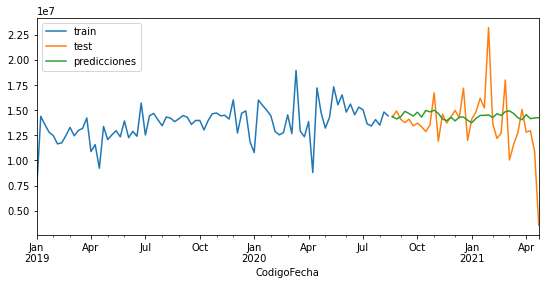

In [82]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [83]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 8378593700154.524
